[![Made withJupyter](https://img.shields.io/badge/Made%20with-Jupyter-orange?style=for-the-badge&logo=Jupyter)](https://jupyter.org/try)

# MNIST generation with DC-GAN

This notebook is freely inspired by the [TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) on Deep Convolutional Generative Adversarial Network (DC-GAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) to build the adversarial networks and the [`tf-gen-models` package](https://pypi.org/project/tf-gen-models/) to implement and run the training procedure.

## What are GANs?

Generative Adversarial Networks [[1](https://arxiv.org/abs/1406.2661)] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  the **discriminator network** ($D$) is trained to distinguish the generator output from the reference dataset;
* while the **generator network** ($G$) is trained to reproduce the reference dataset trying to fake the discriminator.

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1](https://arxiv.org/abs/1406.2661)].

## Mathematical details

The generator $G(z)$, fed by elements $z$ sampled according to a known distribution $p_z$ (typically gaussian), maps the **latent space** $\mathcal{Z}$ to the reference dataset $\mathcal{X}$, inducing a distribution $p_\rm{gen}$ trained to match with the target distribution $p_\rm{ref}$. The discriminator $D(x)$ outputs a single scalar, readable as the **probability** that $x$ comes from the reference dataset rather than $G$. Then, the optimization problem corresponds to train $D$ to maximize the probability of correct labelling, and simultaneously training $G$ to minimize $\log(1 - D(G(z)))$.

Defining the **loss function** $\mathcal{L}_\rm{GAN}$ as follows

<center>$\mathcal{L}_\rm{GAN} = \mathbb{E}_{x \sim p_\rm{ref}} \left[ \log{D(x)} \right] + \mathbb{E}_{z \sim p_\rm{gen}} \left[ \log(1 - D(G(z))) \right]$</center>

the _minimax game_ can be written in this form:

<center>$\min_G \max_D \mathcal{L}_\rm{GAN}$</center>

A unique solution exists, with $G$ recovering the reference distribution $p_\rm{ref}$ and $D$ equal to 1/2 everywhere [[1](https://arxiv.org/abs/1406.2661)].

Traditional GAN systems suffer from many issues, particularly during the training phase:

* generator _collapsing_ to produce only a single sample or a small family of very similar samples;
* generator and discriminator _oscillating_ during training rather than converging to a fixed point;
* if _imbalance_ between the two agents occurs, the system doesn’t learn.

All these issues are related to the **vanishing gradient** problem. In order to fix it, one can add _continuous noise_ to both discriminator and generator. This trick allows to learn thanks to a non-zero gradient [[2](https://arxiv.org/abs/1701.04862)]. The `GAN` class provided by the `tf-gen-models` package implements a training procedure stabilized by **noise injection** as just described.

## What are GANs used for?

GANs are widely used as **generative image model** thanks to their capacity in reproducing highly faithful and diverse images with models learned directly from data [[3](https://arxiv.org/abs/1809.11096)]. The notebook will test GANs in generating *handwritten digits* accordingly to the MNIST dataset. In this example, the latent space elements $z$ will be mapped in a 28x28 space representing the **pixel intensity** of digit images. Both generated images and reference ones will feed the discriminator, trained to distinguish real from fake input. This framework corresponds to the *deep convolutional version* of the minimax game described above [[4](https://arxiv.org/abs/1511.06434)].

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/tf-gen-models/main/.github/images/gan/gan_scheme.png" width="800"/>
</div>



## References

1.  I. J. Goodfellow _et al._, "Generative Adversarial Nets", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661).
2. M. Arjovsky and L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862).
3. A. Brock, J. Donahue and K. Simonyan, "Large Scale GAN Training for High Fidelity Natural Image Synthesis", [arXiv:1809.11096](https://arxiv.org/abs/1809.11096).
4. A. Radford, L. Metz and S. Chintala, "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

## Let's code!

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/tf-gen-models/blob/main/notebooks/gan/0_MNIST_gen_DC-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/tf-gen-models/blob/main/notebooks/gan/0_MNIST_gen_DC-GAN.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

### Setup

In [39]:
## to run the training
!pip install tf-gen-models

## to generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jrs219ly
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-jrs219ly
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173744 sha256=b95342dd1d0e950ed26c5aeaa8ead4ba06791117dcfda6291a544439c54d5342
  Stored in directory: /tmp/pip-ephem-wheel-cache-uafsqfbg/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [40]:
import os
import PIL
import glob
import imageio

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from tensorflow.keras import Sequential, layers
from tf_gen_models.algorithms.gan import GAN

In [41]:
tf.__version__

'2.7.0'

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
train_images = train_images . reshape ( train_images.shape[0], 28, 28, 1 )
train_images . astype ( np.float32 )
train_images = train_images / 255

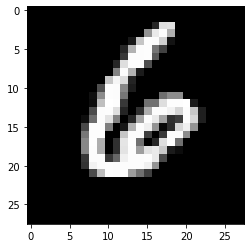

In [36]:
plt.imshow (train_images[13,:,:,0], cmap = "gray")
plt.show()

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
LATENT_DIM = 100
EPOCHS = 5

In [13]:
# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices ( train_images )
train_ds . shuffle ( BUFFER_SIZE )
train_ds . batch ( BATCH_SIZE )
train_ds . cache()
train_ds . prefetch ( tf.data.AUTOTUNE )
train_ds

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float64>

### Create the adversarial players

Both the generator and the discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

#### The generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [43]:
generator = Sequential ( name = "generator" )

generator . add ( layers.Dense ( 7*7*256, use_bias = False, input_shape = (LATENT_DIM,) ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Reshape ( (7, 7, 256) ) )

generator . add ( layers.Conv2DTranspose ( 128, (5, 5), strides = (1, 1), padding = "same", use_bias = False ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Conv2DTranspose ( 64, (5, 5), strides = (2, 2), padding = "same", use_bias = False ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Conv2DTranspose ( 1, (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh" ) )

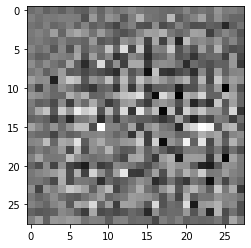

In [44]:
noise = tf.random.normal([1, 100])
gen_image = generator(noise, training=False)

plt.imshow(gen_image[0, :, :, 0], cmap='gray')
plt.show()

#### The discriminator

The discriminator is a CNN-based image classifier.

In [47]:
discriminator = Sequential ( name = "discriminator" )
    
discriminator . add ( layers.Conv2D ( 64, (5, 5), strides = (2, 2), padding = "same", input_shape = [28, 28, 1] ) )
discriminator . add ( layers.LeakyReLU() )
discriminator . add ( layers.Dropout (0.3) )

discriminator . add ( layers.Conv2D ( 128, (5, 5), strides = (2, 2), padding = "same" ) )
discriminator . add ( layers.LeakyReLU() )
discriminator . add ( layers.Dropout (0.3) )

discriminator . add ( layers.Flatten() )
discriminator . add ( layers.Dense ( 1, activation = "sigmoid" ) )

In [48]:
decision = discriminator(gen_image)
print (decision)

tf.Tensor([[0.5000984]], shape=(1, 1), dtype=float32)


### Training procedure

In [31]:
gan = GAN (generator, discriminator, latent_dim = LATENT_DIM)
gan . summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_9 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 7, 7, 128)        51

In [32]:
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)

gan . compile (g_optimizer, d_optimizer)

In [33]:
train = gan . fit (train_images, epochs = EPOCHS)

Epoch 1/5
1875/1875 [==============================] - 84s 43ms/step - mse: 0.1898 - d_loss: 0.6897 - g_loss: -0.6904 - d_lr: 1.0000e-04 - g_lr: 1.0000e-04
Epoch 2/5
1875/1875 [==============================] - 85s 46ms/step - mse: 0.1261 - d_loss: 0.9488 - g_loss: -0.9484 - d_lr: 1.0000e-04 - g_lr: 1.0000e-04
Epoch 3/5
1875/1875 [==============================] - 86s 46ms/step - mse: 0.1279 - d_loss: 1.2788 - g_loss: -1.2795 - d_lr: 1.0000e-04 - g_lr: 1.0000e-04
Epoch 4/5
1875/1875 [==============================] - 85s 45ms/step - mse: 0.1287 - d_loss: 1.3081 - g_loss: -1.3082 - d_lr: 1.0000e-04 - g_lr: 1.0000e-04
Epoch 5/5
1875/1875 [==============================] - 84s 45ms/step - mse: 0.1303 - d_loss: 1.3049 - g_loss: -1.3036 - d_lr: 1.0000e-04 - g_lr: 1.0000e-04


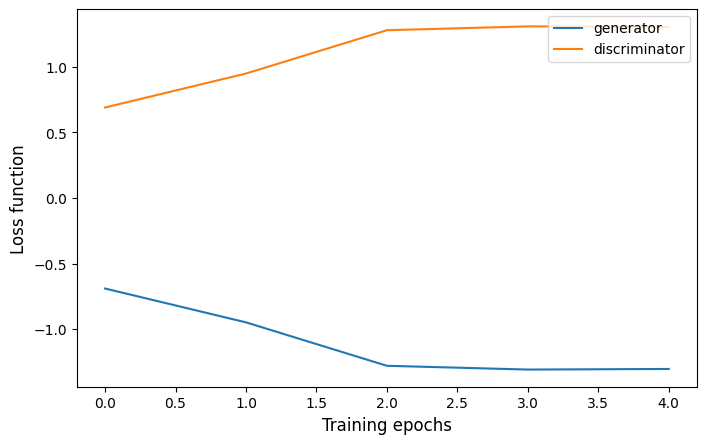

In [34]:
plt.figure (figsize = (8,5), dpi = 100)
plt.xlabel ("Training epochs", fontsize = 12)
plt.ylabel (f"{gan.loss_name}", fontsize = 12)
plt.plot (train.history["g_loss"], label = "generator")
plt.plot (train.history["d_loss"], label = "discriminator")
plt.legend (loc = "upper right", fontsize = 10)
plt.show()

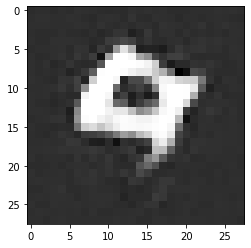

In [35]:
gen_image = gan.generate ( batch_size = 1 )

plt.imshow ( gen_image[0, :, :, 0], cmap = "gray" )
plt.show()